In [1]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

app_train = pd.read_csv('C:/Users/farma/Downloads/home-credit-default-risk/application_train.csv',encoding='latin1')
app_test = pd.read_csv('C:/Users/farma/Downloads/home-credit-default-risk/application_test.csv',encoding='latin1')

# app_train.head()

# data preprocessing

# Label encoding
le = LabelEncoder()

for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:

            le.fit(app_train[col])

            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])

# one-hot encoding            
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

# print('Training Features shape: ', app_train.shape)
# print('Testing Features shape: ', app_test.shape)

train_labels = app_train['TARGET']

app_train, app_test = app_train.align(app_test, join='inner', axis=1)

app_train['TARGET'] = train_labels

# print('Training Features shape: ', app_train.shape)
# print('Testing Features shape: ', app_test.shape)

# model
from sklearn.preprocessing import MinMaxScaler, Imputer

# Drop the target from the training data
if 'TARGET' in app_train:
    train = app_train.drop(columns=['TARGET'])
else:
    train = app_train.copy()

# Feature names
features = list(train.columns)

test = app_test.copy()

# Mean imputation of missing values
imputer = Imputer(strategy='mean')

# Normalizer
scaler = MinMaxScaler(feature_range=(0, 1))

imputer.fit(train)

# Transform both training and testing data
train = imputer.transform(train)
test = imputer.transform(app_test)

scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

# print('Training data shape: ', train.shape)
# print('Testing data shape: ', test.shape)

from sklearn.decomposition import PCA

pca = PCA(.95)
pca.fit(train)

train = pca.transform(train)
test = pca.transform(test)

# print('Training data shape: ', train.shape)
# print('Testing data shape: ', test.shape)

from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()

# Train and predictions
log_reg.fit(train, train_labels)
log_reg_pred = log_reg.predict_proba(test)[:, 1]

C:\Users\farma\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\farma\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [33]:
#submission to kaggle

submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = log_reg_pred

# submit.head()

submit.to_csv('log_reg.csv', index = False)

# best accuracy :0.729

C:\Users\farma\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [19]:
# visualize coefficients with feature names
results = pd.DataFrame(sorted(zip(np.transpose(log_reg.coef_).flatten(),features)))

neg_top_5 = results.head(5)
print(neg_top_5)
pos_top_5 = results.tail(5)
print(pos_top_5)

          0                     1
0 -1.267065          LANDAREA_AVG
1 -1.080272       YEARS_BUILD_AVG
2 -1.033934         FLOORSMAX_AVG
3 -0.442552       FLAG_OWN_REALTY
4 -0.348165  LIVINGAPARTMENTS_AVG
           0                            1
73  0.624191               COMMONAREA_AVG
74  0.658473  YEARS_BEGINEXPLUATATION_AVG
75  0.714675             FLAG_CONT_MOBILE
76  0.796266               ELEVATORS_MODE
77  1.579621            BASEMENTAREA_MODE


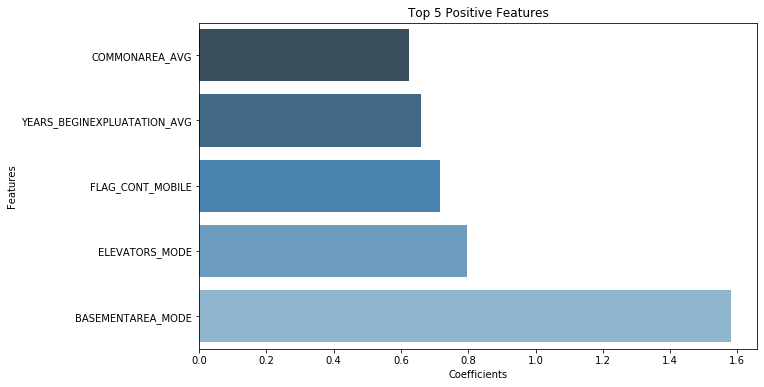

In [34]:
# Plot top 5 coefficients
plt.figure().set_size_inches(10, 6)
fg3 = sns.barplot(x=0, y=1,data=pos_top_5, palette="Blues_d")
# fg3.set_xticklabels(rotation=35, labels=logReg_coeff_top.feature_name)
plt.ylabel('Features')
plt.xlabel('Coefficients')
plt.title('Top 5 Positive Features')
plt.savefig('pos_top_5')

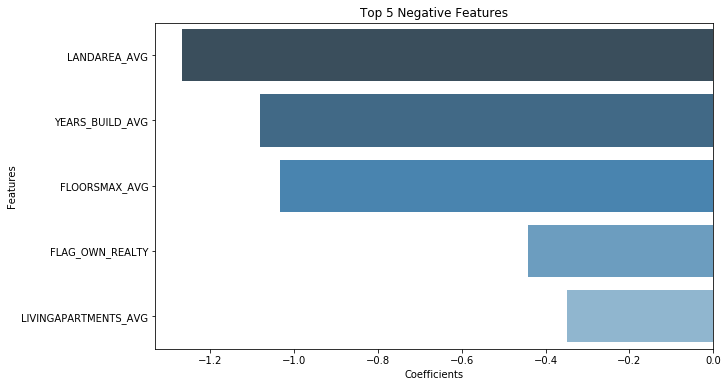

In [35]:
# Plot top 5 coefficients
plt.figure().set_size_inches(10, 6)
fg3 = sns.barplot(x=0, y=1,data=neg_top_5, palette="Blues_d")
# fg3.set_xticklabels(rotation=35, labels=logReg_coeff_top.feature_name)
plt.ylabel('Features')
plt.xlabel('Coefficients')
plt.title('Top 5 Negative Features')
plt.savefig('neg_top_5')

In [32]:
log_reg.intercept_.flatten()

array([-2.75767889])

In [10]:
#finding optimal no.of clusters using elbow method
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(train)
    Sum_of_squared_distances.append(km.inertia_)

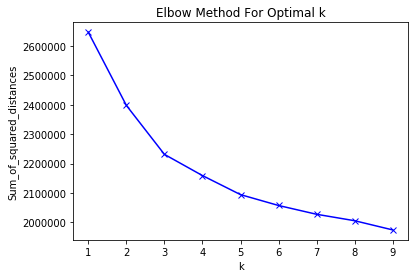

In [11]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()
plt.savefig('elbow method')

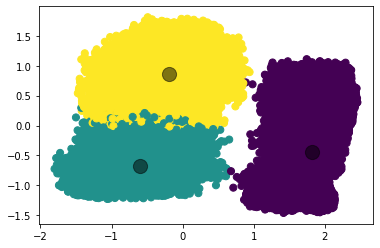

In [12]:
#clustering of customer profiling
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3)
kmeans.fit(train)
y_kmeans = kmeans.predict(train)
plt.scatter(train[:, 0], train[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.savefig('k=3')